In [1]:
import visa
import time
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import date

C:\Users\oper\Desktop\labparamp\Env\paramp\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


In [2]:
%matplotlib inline

In [3]:
#PER I FILE: i percorsi con r -> es: r'C:\user\bla\bla' e i file senza estensione -> es: S21.csv andrà passato come 'S21'

In [4]:
root = r'C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\notebooks\data'

In [5]:
class vna(object):

    def __init__(self, visaname):
        
        visaname = ('TCPIP::'+ str(visaname) +'::INSTR')  # 'visaname' is the IP
        self.rm = visa.ResourceManager()
        self.pyvisa = self.rm.open_resource(visaname) # command to open the connection
     
        
     # main commands
    
    def read(self):
        return self.pyvisa.read()

    
    def write(self, string):
        self.pyvisa.write(string)

        
    def query(self, string):
        msg = self.pyvisa.query(string)
        #print(msg)
    
        return  msg
    
    # commands
    
    def close(self):
        self.pyvisa.close()
    
     
    def reset(self):
        self.write('*RST')
        
    
    def get_idn(self):
        id = self.query('*IDN?')
        
        return id
       
    def VNAinit(self):
        self.query('INST:SEL "NA"*OPC?')
        

        
    def select_mode(self, mode):
        if mode == 'VNA':
            cmd='INST:SEL "NA"*OPC?'
        elif mode == 'PSA':
            cmd='INST:SEL "SA"*OPC?'
        elif mode == 'CAT':
            cmd='INST:SEL "CAT"*OPC?'
        else:
            cmd='INST:SEL "NA"*OPC?'
            
        self.query(cmd)

    
    def autoscale(self):
        
        # Make active the trace 1
        trace = 1
        self.query('CALC:PAR' + str(trace) + ':SEL*OPC?')
        
        pause(3)
        
        # Autoscale for the printlayed trace number
        self.query('DISP:WIND:TRAC' + str(trace) + ':Y:AUTO*OPC?')
        
        pause(3)
    
    
    def average(self, navgs):
        
        navgs = round(abs(navgs))
        if navgs > 100:
            navgs = 100
            
        # Set the averaging stat
        self.write('AVER:ENAB 1')

        # Set the number of sweep averages
        self.query('AVER:COUN ' + str(navgs) + '*OPC?')
    
    
    def get_average(self):
        navgs = int(self.query('AVER:COUN?'))
        print('Number of averages = ' + str(navgs))
    
        return navgs
    
    def clear_average(self):
        self.write('AVER:CLE')

    def get_minimum(self): #gets the frequency (in GHz at which the signal is minimum
        
        # Make active the trace 1
        trace = 1
        self.query('CALC:PAR' + str(trace) + ':SEL*OPC?')
        
        # Specified marker the lowest (minimum) amplitude of the trace
        marker = 1
        self.query('CALC:MARK' + str(marker) + ':FUNC:MIN*OPC?')
        fmin = self.query('CALC:MARKer' + str(marker) + ':X?')
        fmin = float(fmin) / 10E8
        print('The minimum is at ' + str(fmin) + ' GHz')
        
        return fmin
    
    def set_range(self, fmin, fmax):
        
        # Set and the stop frequency of the trace
        self.query('FREQ:START ' + str(fmin) + '*OPC?')

        # Set and the stop frequency of the trace
        self.query('FREQ:STOP ' + str(fmax) + '*OPC?')

    
    def get_freq_span(self):
        
        # Set and the stop frequency of the trace
        freqspan = float(self.query('FREQ:SPAN?'))

        # Wait
        self.query('*OPC?')

        return freqspan
    
    def set_sweep_points(self,npoints):

        npoints = round(abs(npoints))

        if npoints > 10001:
            npoints = 10001
        

        # Set and the number of data points in the trace.
        query('SWE:POIN ' + str(npoints) + ';*OPC?')

    
    def set_smoothing(self, status):
        
        # Make active the trace 1
        trace=1
        self.write('CALC:PAR' + str(trace) + ':SEL')

        if status:
            # Smoothing occurs on the selected trace
            self.write('CALC:SMO 1')

            # Set smoothing aperture for the selected trace.
            self.write('CALC:SMO:APER 5')
        else:
            self.write('CALC:SMO 0')

    def set_bandwidth(self, bw):
        
        # Make active the trace 1
        trace=1
        self.write('CALC:PAR' + str(trace) + ':SEL')

        bw = abs(bw)
        if bw < 10:
            bw = 10
        if bw > 30e3:
            bw = 30e3

        self.write('BWID ' + str(bw) + '*OPC?')
 
    def print_data(self, folder = None, filename = None): #nome file senza estensione
        
        freqs = self.query('FREQuency:DATA?')
        self.query('*OPC?')
        data = self.query('CALC:DATA:FDAT?')
        self.query('*OPC?')
        
        if folder != None and filename != None:
            file = open(root + '\\' + folder + '\\' + filename + '.csv', 'w', encoding='utf-8')
            file.write(str(freqs))
            file.write(str(data))
            file.close()
            
        freqs = freqs.split(',')
        freqs = list(map(float, freqs))
        data = data.split(',')
        data = list(map(float, data))
        
        if folder != None and  filename != None:
            plt.figure(figsize=(20,15))
            freqs = [float(element) * 1e-9 for element in freqs]
            plt.plot(freqs,data)
            plt.grid()
            plt.xlabel('Frequencies (GHz)', fontsize=20)
            plt.ylabel('Power (dB)', fontsize=20)
            plt.title(filename, fontsize=24)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.savefig(root + '\\' + folder + '\\' + filename + '.png')
            plt.close()

        return [freqs, data]
    
    def read_IQ_after_avgs(self, folder = None, filename = None):

        # Make active the trace 1
        trace=1
        self.write('CALC:PAR' + str(trace) + ':SEL')

        # Set and query printlayed data format to Log magnitude
        self.query('CALC:FORMat MLOG*OPC?')

        # Resets sweep averaging to zero 
        self.write('AVER:CLE')

        # Set single sweep mode
        self.query('INIT:CONT 0*OPC?')

        for i in range(1,float(self.query('AVER:COUN?'))):
            # Causes the FieldFox to perform a single sweep, then hold
            self.query('INIT:IMM*OPC?')

            print('  Acquiring S21 number ' + str(i))


        # Set and query printlayed data format to real
        self.query('CALC:FORMat REAL*OPC?')

        # Set Autoscale
        self.autoscale()

        # Read I data
        [freqs, I] = self.print_data(folder, filename)

        # Set and query printlayed data format to imaginary
        self.query('CALC:FORMat IMAG*OPC?')
        # Set Autoscale
        self.autoscale()

        # Read Q data
        [freqs, Q] = self.print_data(folder, filename)

        # Set and query printlayed data format to Log magnitude
        self.query('CALC:FORMat MLOG*OPC?')

        # Set Autoscale
        self.autoscale()

        # Set continuous sweep mode
        self.query('INIT:CONT 1*OPC?')

        return [freqs, I, Q]

    def read_after_avgs(self, folder = None, filename = None):

        # Make active the trace 1
        trace=1
        self.write('CALC:PAR' + str(trace) + ':SEL')

        # Set and query printlayed data format to Log magnitude
        self.write('CALC:FORMat MLOG')

        # Resets sweep averaging to zero 
        self.write('AVER:CLE')

        # Set single sweep mode
        self.query('INIT:CONT 0*OPC?')

        for i in range(1,float(self.query('AVER:COUN?'))):
            # Causes the FieldFox to perform a single sweep, then hold
            self.query('INIT:IMM*OPC?')
            
            print('  Acquiring S21 trace number ' + str(i))


        # Read S21 data
        [freqs, data]= self.print_data(folder, filename)

        # Set continuous sweep mode
        self.write('INIT:CONT 1*OPC?')
        
        return [freqs, data]


    def set_power(self, powerdBm):

        if powerdBm>3:
            powerdBm=3

        elif powerdBm<-45:
            powerdBm=-45

        #Set power level from +3 to -45 dBm in .1 dB steps.
        self.write('SOUR:POW ' + str(round(powerdBm,1)))
        


    def single_scan(self, fmin, fmax, powerdBm, npoints, navgs, folder = None, filename = None):


        # Set window range
        set_range(fmin, fmax)

        # Set VNA output power
        set_power(powerdBm)

        # Set number of sweep point
        self.setSweepPoints(npoints)

        # Set number of average
        self.average(navgs)

        # Set Bandwidth 
        #self_set_bandwidth(10e3)
        self.set_bandwidth(1e3)

        # Set Autoscale
        self.autoscale()

        # Read data after navgs averages
        [freqs, power] = read_after_avgs(folder, filename)

        # Set Autoscale
        self.autoscale()

        # Set number of average
        self.average(1)

        return [freqs, power]

In [6]:
#def my_plot(f, d, folder, plot_title):
def my_plot(f, d, plot_title = None):
    plt.figure(figsize=(20,15))
    f = f * 1e-9
    plt.plot(f,d)
    plt.grid()
    plt.xlabel('Frequencies (GHz)', fontsize=20)
    plt.ylabel('Power (dB)', fontsize=20)
    if plot_title != None:
        plt.title(plot_title, fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.savefig(folder + '\\' + plot_title + '.png')
    plt.show()

def import_csv(folder, filename):  #filename w/o extension  
    data = []
    with open(root + '\\' + folder + '\\' + filename + '.csv') as csvfile:
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            data.append(row)
    f = np.array(data[0])
    d = np.array(data[1])
    my_plot(f, d, filename)
    #my_plot(f, d, folder, filename)
    return f, d

def get_date():
    today = date.today()
    d1 = today.strftime("%d-%m-%Y")
    return d1

In [7]:
field_fox = vna('192.168.3.3')

In [8]:
field_fox.query('*IDN?')

'Keysight Technologies,N9916A,MY53104702,A.08.01\n'

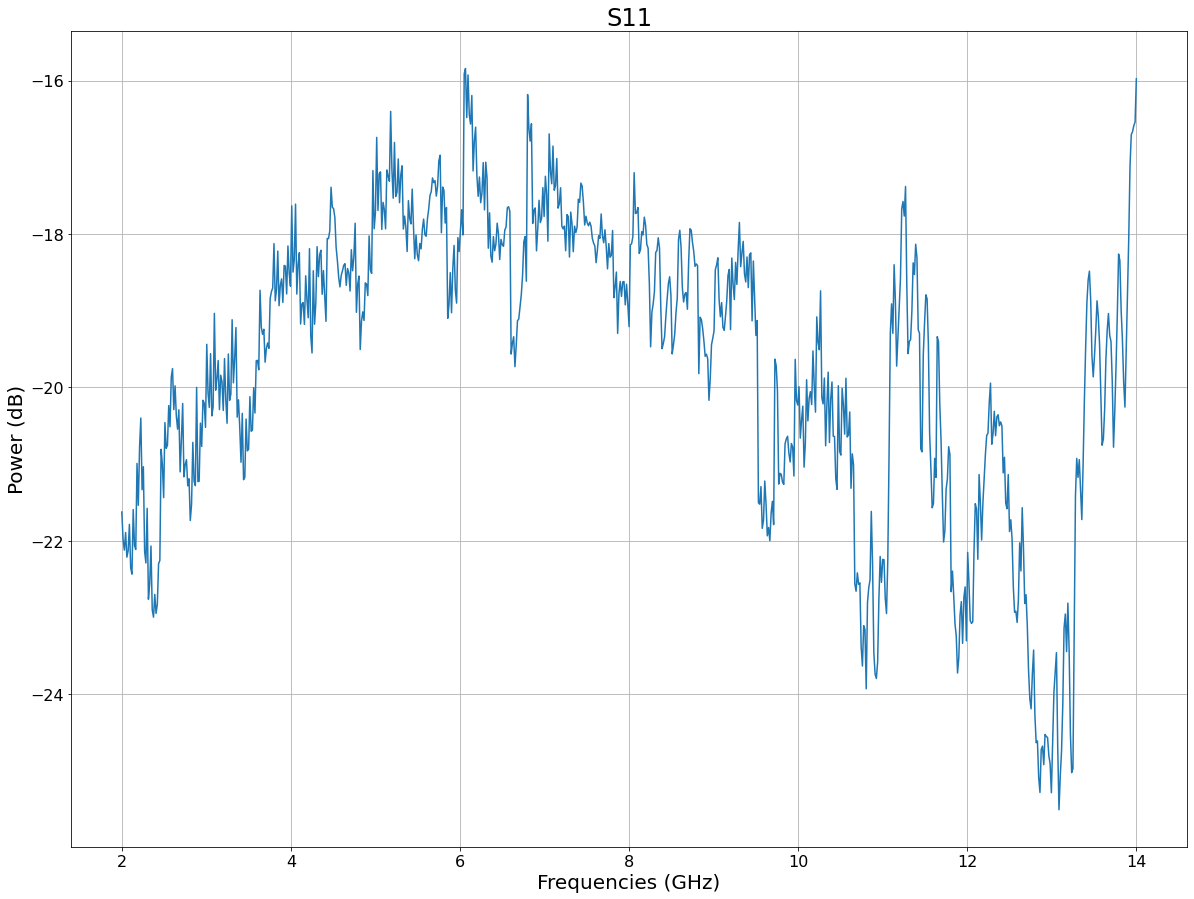

In [9]:
f, d = import_csv('04-05', 'S11')

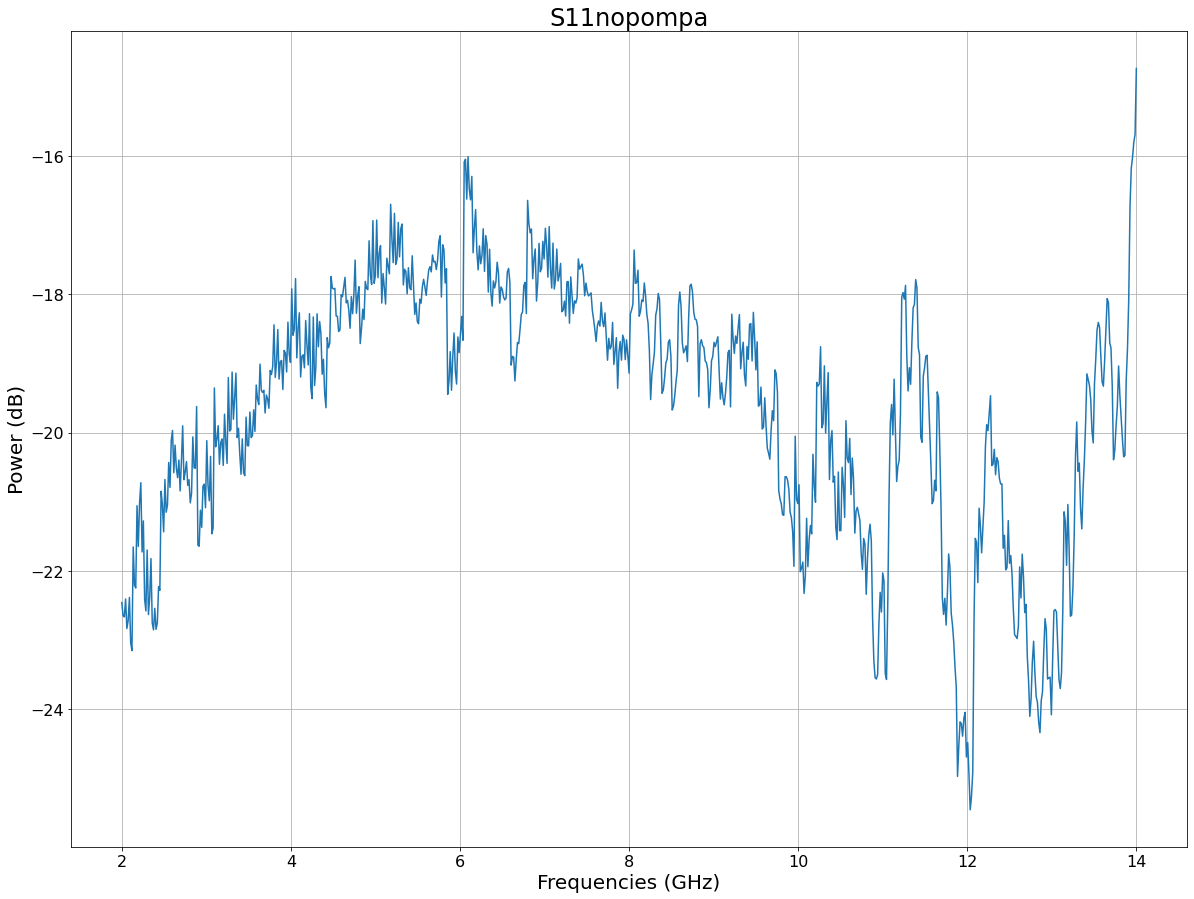

In [10]:
f2, d2 = import_csv('04-05', 'S11nopompa')

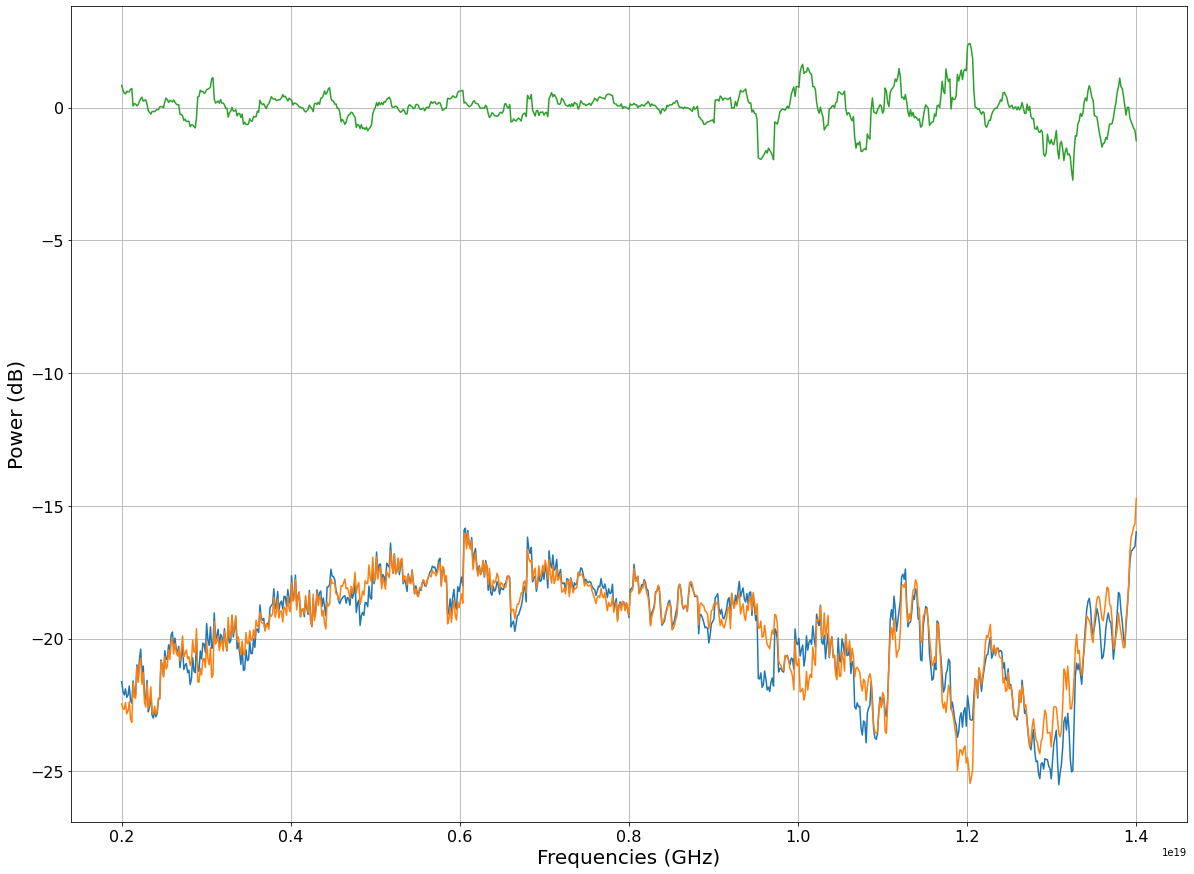

In [11]:
plt.figure(figsize=(20,15))
f = f * 1e9
plt.plot(f,d)
plt.plot(f,d2)
plt.plot(f,d-d2)
plt.grid()
plt.xlabel('Frequencies (GHz)', fontsize=20)
plt.ylabel('Power (dB)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(r'C:\Users\oper\Desktop\labparamp\QTLab2122\TWPA\notebooks\data\04-05.png')
plt.show()

In [12]:
f,d=field_fox.print_data()

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [11]:
d

array([-21.62523214, -21.98217471, -22.12131501, -21.89256709,
       -22.21335707, -22.13048079, -21.78658804, -22.35198338,
       -22.43552077, -21.59305938, -22.06317981, -22.11345508,
       -20.99165897, -21.53740985, -20.78486186, -20.39967174,
       -21.33447603, -21.03396751, -22.14002427, -22.28869222,
       -21.57708511, -22.76236413, -22.55916021, -22.0686863 ,
       -22.89992496, -22.99617751, -22.69948043, -22.94717903,
       -22.82999523, -22.29973184, -22.25600941, -20.80764818,
       -21.01154729, -21.43746939, -20.45910071, -20.79488628,
       -20.75505085, -20.23763416, -20.51435632, -19.86745439,
       -19.75490509, -20.28964297, -19.98005739, -20.37553462,
       -20.54426794, -20.29258   , -21.1015161 , -20.67919623,
       -20.20993286, -21.16603968, -21.00612741, -20.94288941,
       -21.28372141, -21.19178762, -21.73585701, -21.52601463,
       -20.71697199, -21.2248596 , -21.28137664, -19.99988027,
       -21.22845214, -21.22395066, -20.46605181, -20.77